<a href="https://colab.research.google.com/github/JulbautistaT/Proyecto_Homicidios/blob/main/RandomForestClassifierDefinitivo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def preprocess_data(df):
    """Preprocesamiento con mayor reducción de información"""
    df_processed = df.copy()

    # Simplificar características temporales al máximo
    df_processed['fecha'] = pd.to_datetime(df_processed['Fecha_hecho'], format='%d/%m/%Y')
    df_processed['semestre'] = (df_processed['fecha'].dt.month > 6).astype(int)  # Solo 2 períodos
    df_processed['año'] = df_processed['fecha'].dt.year

    # Estadísticas semestrales muy básicas
    semester_stats = df_processed.groupby(['Municipio', 'año', 'semestre'])['Cantidad'].agg([
        ('avg_accidents', 'mean')
    ]).reset_index()

    df_processed = df_processed.merge(
        semester_stats,
        on=['Municipio', 'año', 'semestre'],
        how='left'
    )

    # Agrupación muy agresiva de categorías
    categorical_columns = ['Departamento', 'Municipio', 'Armas_medios']

    for col in categorical_columns:
        # Mantener solo las top N categorías más frecuentes
        top_n = 5 if col != 'Municipio' else 10
        top_categories = df_processed[col].value_counts().nlargest(top_n).index
        df_processed[col] = df_processed[col].apply(lambda x: x if x in top_categories else 'Other')

        # Codificación con ruido significativo
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
        noise = np.random.normal(0, 0.1, size=len(df_processed))
        df_processed[f'{col}_encoded'] = df_processed[f'{col}_encoded'] + noise

    # Normalización con ruido significativo
    scaler = StandardScaler()
    df_processed['avg_accidents'] = scaler.fit_transform(df_processed[['avg_accidents']])
    df_processed['avg_accidents'] += np.random.normal(0, 0.15, size=len(df_processed))

    return df_processed

In [ ]:
def prepare_features(df):
    """Conjunto mínimo de features"""
    features = [
        'Departamento_encoded',
        'Municipio_encoded',
        'semestre',
        'avg_accidents'
    ]
    return df[features]


In [ ]:
def create_target_variable(df):
    """
    Target variable con umbral dinámico y ruido
    """
    semester_accidents = df.groupby(['Municipio', 'año', 'semestre'])['Cantidad'].mean().reset_index()

    # Añadir ruido significativo
    noise = np.random.normal(0, semester_accidents['Cantidad'].std() * 0.2, size=len(semester_accidents))
    semester_accidents['Cantidad'] += noise

    # Umbral dinámico basado en la mediana móvil
    rolling_median = semester_accidents['Cantidad'].rolling(window=3, min_periods=1).median()
    threshold = rolling_median * 1.2  # 20% sobre la mediana móvil

    high_risk = semester_accidents['Cantidad'] > threshold
    risk_labels = semester_accidents.assign(is_high_risk=high_risk.astype(int))

    return df.merge(
        risk_labels[['Municipio', 'año', 'semestre', 'is_high_risk']],
        on=['Municipio', 'año', 'semestre'],
        how='left'
    )['is_high_risk']

In [ ]:
def train_model(X, y):
    """Entrenamiento con submuestreo y parámetros muy restrictivos"""
    # Submuestreo de la clase mayoritaria
    X_df = pd.DataFrame(X)
    y_df = pd.Series(y)

    # Separar clases
    df_majority = X_df[y_df == 0]
    df_minority = X_df[y_df == 1]

    # Submuestreo de la clase mayoritaria
    df_majority_downsampled = resample(
        df_majority,
        n_samples=len(df_minority) * 3,  # Mantener ratio 3:1
        random_state=42
    )

    # Combinar datasets
    X_balanced = pd.concat([df_majority_downsampled, df_minority])
    y_balanced = pd.concat([
        pd.Series(0, index=df_majority_downsampled.index),
        pd.Series(1, index=df_minority.index)
    ])

    # Split con datos balanceados
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced,
        test_size=0.3,
        random_state=42,
        stratify=y_balanced
    )

    model = RandomForestClassifier(
        n_estimators=30,          # Muy pocos árboles
        max_depth=3,              # Profundidad muy limitada
        min_samples_split=30,     # Muestras mínimas muy altas
        min_samples_leaf=20,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        bootstrap=True,
        max_samples=0.5           # Usar solo 50% de las muestras
    )

    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\nCV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    model.fit(X_train, y_train)

    return model, X_test, y_test

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluación completa del modelo"""
    predictions = model.predict(X_test)
    probas = model.predict_proba(X_test)

    print("\nReporte de clasificación:")
    print(classification_report(y_test, predictions))

    # Matriz de confusión
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()

    # Importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nImportancia de características:")
    print(feature_importance)

    # Distribución de probabilidades
    plt.figure(figsize=(8, 6))
    plt.hist(probas[:, 1], bins=50)
    plt.title('Distribución de Probabilidades Predichas')
    plt.xlabel('Probabilidad de Clase 1')
    plt.ylabel('Frecuencia')
    plt.show()

    return feature_importance

In [ ]:
def make_prediction(model, new_data, scaler=None):
    """
    Realiza predicciones para nuevos datos

    Args:
        model: Modelo entrenado
        new_data: DataFrame con las características necesarias
        scaler: Objeto StandardScaler (opcional)

    Returns:
        Tuple con predicción (0 o 1) y probabilidad de clase positiva
    """
    # Hacer la predicción
    prediction = model.predict(new_data)[0]
    probability = model.predict_proba(new_data)[0][1]

    return prediction, probability

In [ ]:
# 1. Cargar los datos
print("Cargando datos...")
df = pd.read_csv('/content/Homicidios_limpio (1).csv')

Cargando datos...


In [ ]:
# 2. Procesar los datos
print("Procesando datos...")
df_procesado = preprocess_data(df)
df_procesado.info()

Procesando datos...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22920 entries, 0 to 22919
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Departamento          22920 non-null  object        
 1   Municipio             22920 non-null  object        
 2   Armas_medios          22920 non-null  object        
 3   Fecha_hecho           22920 non-null  object        
 4   Genero                22920 non-null  object        
 5   Grupo_etario          22920 non-null  object        
 6   Cantidad              22920 non-null  int64         
 7   fecha                 22920 non-null  datetime64[ns]
 8   semestre              22920 non-null  int64         
 9   año                   22920 non-null  int32         
 10  avg_accidents         22920 non-null  float64       
 11  Departamento_encoded  22920 non-null  float64       
 12  Municipio_encoded     22920 non-null  float64       
 

In [ ]:
# 3. Crear variable objetivo
y = create_target_variable(df_procesado)

In [ ]:
# 4. Preparar características
X = prepare_features(df_procesado)

In [ ]:
# 5. Entrenar modelo
print("Entrenando modelo...")
modelo, X_test, y_test = train_model(X, y)

Entrenando modelo...

CV Scores: [0.98913043 0.97826087 0.91304348 0.93478261 0.95604396]
Mean CV Score: 0.954 (+/- 0.056)


Evaluando modelo...

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       148
           1       0.73      0.96      0.83        49

    accuracy                           0.90       197
   macro avg       0.86      0.92      0.88       197
weighted avg       0.92      0.90      0.91       197



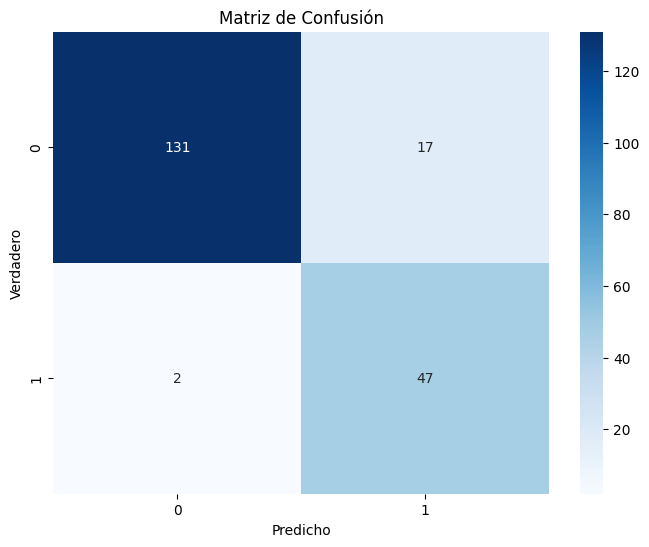


Importancia de características:
                feature  importance
3         avg_accidents    0.617636
1     Municipio_encoded    0.345600
0  Departamento_encoded    0.034353
2              semestre    0.002412


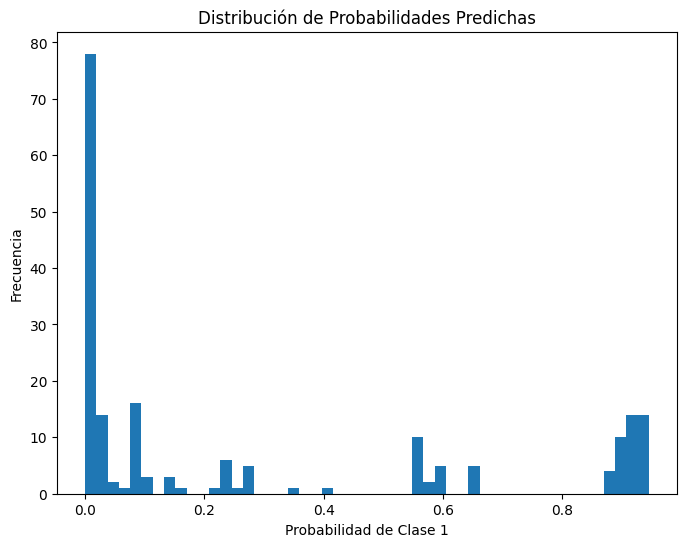

,feature,importance
3,avg_accidents,0.617636
1,Municipio_encoded,0.345600
0,Departamento_encoded,0.034353
2,semestre,0.002412


In [ ]:
# 6. Evaluar modelo
print("Evaluando modelo...")
evaluate_model(modelo, X_test, y_test)

In [ ]:
# 7. Ejemplo de predicción
print("\nEjemplo de predicción:")
# Crear un ejemplo de nuevo dato
nuevo_dato = pd.DataFrame({
    'Departamento_encoded': [2.1],  # Valor ejemplo con ruido
    'Municipio_encoded': [5.2],     # Valor ejemplo con ruido
    'semestre': [1],                # Segundo semestre
    'avg_accidents': [0.5]          # Valor normalizado ejemplo
})

# Realizar predicción
prediccion, probabilidad = make_prediction(modelo, nuevo_dato)

print(f"Datos de entrada:")
print(nuevo_dato)
print(f"\nPredicción: {'Alto riesgo' if prediccion == 1 else 'Bajo riesgo'}")
print(f"Probabilidad de alto riesgo: {probabilidad:.2%}")


Ejemplo de predicción:
Datos de entrada:
   Departamento_encoded  Municipio_encoded  semestre  avg_accidents
0                   2.1                5.2         1            0.5

Predicción: Bajo riesgo
Probabilidad de alto riesgo: 5.52%
